In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from loader import PathDataModule
from tqdm import tqdm

# --- 1. Configuration and Data Loading ---
config_path = 'full.json'
config_data = json.load(open(config_path, 'r'))
print(config_data)

{'dataset': 'ogbl-collab', 'storage_dir': '../data/', 'embedding_config': './full_embedding.json', 'train_ratio': 0.3, 'hidden_dim': 128, 'max_hops': 4, 'num_threads': 16, 'max_epochs': 3, 'batch_size': 128, 'dim_feedforward': 128, 'nhead': 4, 'num_layers': 3, 'dropout': 0.1, 'store': 'model', 'save_text_embeddings': True, 'shallow': True, 'pre_scan': ['train'], 'adjust_no_neg_paths_samples': True, 'max_adjust': 5.0, 'embedding': 'all', 'test_time': 2, 'num_ckpt': 2, 'scale_loss': True, 'chi2': False}


In [5]:
import os, requests, json, pprint

cid  = os.getenv("CONTAINER_ID")          # ← set by Vast.ai inside every container
key  = os.getenv("CONTAINER_API_KEY")     # ← scoped token for this one instance
assert cid and key, "Not running on a Vast.ai container!"

resp = requests.get(
    f"https://console.vast.ai/api/v0/instances/{cid}/",
    headers={"Authorization": f"Bearer {key}",
             "accept": "application/json"},
    timeout=10,
)

info = resp.json()
print("Effective vCPUs:", info['instances']["cpu_cores_effective"])
# print(info['instances'].keys())

Effective vCPUs: 20.0


In [2]:

# Initialize the DataModule and load the data
print("Setting up DataModule...")
dm = PathDataModule(config_path=config_path, batch_size=32)
dm.setup('fit')
print("Data loaded.")


Setting up DataModule...
Setting up data for stage: fit
Setting up data for split: train
Pre-scan enabled for train split. Running full data validation...

--- Pre-scanning and filtering train data points ---
Scanning 855944 edges in train split...


Scanning edges: 100%|██████████| 855944/855944 [00:01<00:00, 735046.70it/s]



Pre-scan Results for train:
  Total edges scanned: 855944
  Valid edges (has pos & neg paths): 247104 (28.9%)
  Missing positive paths: 594364 (69.4%)
  Missing negative paths: 608840 (71.1%)
  Empty negative paths: 0 (0.0%)

⚠️  WARNING: Some edges are missing required path data!
  Filtering train split to keep only 247104 valid edges.
  New edge count for train: 247104
--- Pre-scan complete ---

Use shallow embeddings: True at config ./full_embedding.json
Loading KGE model proxy for train split from ../data/transe_ogbl-collab_all_config.json
KGEModelProxy initialized on cuda
Loaded model state from ../data/transe_ogbl-collab_all_model.pt to cuda
Device for KGE model: cuda:0
Loaded 247104 edges for train split.
Setting up data for split: valid


/workspace/src/v4/embedding.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


Pre-scan not configured for valid split. Skipping data validation.
Use shallow embeddings: True at config ./full_embedding.json
Loading KGE model proxy for valid split from ../data/transe_ogbl-collab_all_config.json
KGEModelProxy initialized on cuda
Loaded model state from ../data/transe_ogbl-collab_all_model.pt to cuda
Device for KGE model: cuda:0
Loaded 160084 edges for valid split.
Setting up data for split: test
Pre-scan not configured for test split. Skipping data validation.
Use shallow embeddings: True at config ./full_embedding.json
Loading KGE model proxy for test split from ../data/transe_ogbl-collab_all_config.json
KGEModelProxy initialized on cuda
Loaded model state from ../data/transe_ogbl-collab_all_model.pt to cuda
Device for KGE model: cuda:0
Loaded 146329 edges for test split.
Data loaded.


In [3]:

# --- 2. Data Extraction and Preparation ---
plot_data = []
split = 'test'  # You can change this to 'valid' or 'test'

print(f"Processing data for '{split}' split...")
edges_df = dm.data[split]
pos_paths = dm.pos_paths[split]
neg_paths = dm.neg_paths[split]


Processing data for 'test' split...


In [4]:
print(len(pos_paths), len(neg_paths))

48963 46064


In [5]:

for eid, row in tqdm(edges_df.iterrows(), total=len(edges_df), desc="Extracting paths"):
    eid_str = str(eid)
    label = row['label']
    edge_meta = {}

    # Process positive path
    if eid_str in pos_paths and pos_paths[eid_str].get('nodes'):
        pos_path_len = len(pos_paths[eid_str]['nodes'])
        edge_meta = {
            'path_length': pos_path_len,
            # 'path_type': 'positive',
            'label': 'true_link' if label == 1 else 'false_link'
        }
    else:
        edge_meta = {
            'path_length': 0,
            # 'path_type': 'positive',
            'label': 'true_link' if label == 1 else 'false_link'
        }

    # Process negative paths
    if eid_str in neg_paths:
        # for neg_path_interleaved in neg_paths[eid_str]:
        #     # As per loader.py, nodes are at even indices
        #     neg_path_len = len(neg_path_interleaved[::2])
        #     plot_data.append({
        #         'path_length': neg_path_len,
        #         'path_type': 'negative',
        #         'label': 'true_link' if label == 1 else 'false_link'
        #     })
        edge_meta["num_neg"] = len(neg_paths[eid_str])

    plot_data.append(edge_meta)

Extracting paths: 100%|██████████| 146329/146329 [00:10<00:00, 14242.94it/s]


In [6]:

plot_df = pd.DataFrame(plot_data)
print("Data prepared for plotting.")


Data prepared for plotting.


In [7]:

# # --- 3. Visualization ---
# if not plot_df.empty:
#     print("Generating plots...")
#     # Set plot style
#     sns.set_theme(style="whitegrid")

#     # Create a scatter plot (strip plot) to show the distribution
#     plt.figure(figsize=(16, 9))
#     sns.stripplot(data=plot_df, x='path_length', y='path_type', hue='label',
#                   jitter=0.35, alpha=0.6, dodge=True, palette={'true_link': 'blue', 'false_link': 'red'})
#     plt.title(
#         f'Path Length Scatter Plot for {split.capitalize()} Set', fontsize=18)
#     plt.xlabel('Path Length (Number of Nodes)', fontsize=12)
#     plt.ylabel('Path Type', fontsize=12)
#     plt.xticks(range(plot_df['path_length'].min(),
#                plot_df['path_length'].max() + 1))
#     plt.legend(title='Edge Label')
#     plt.show()

#     # Create a box plot for a clearer summary of the distributions
#     plt.figure(figsize=(16, 9))
#     sns.boxplot(data=plot_df, x='path_length', y='path_type', hue='label',
#                 palette={'true_link': 'blue', 'false_link': 'red'})
#     plt.title(
#         f'Path Length Distribution for {split.capitalize()} Set', fontsize=18)
#     plt.xlabel('Path Length (Number of Nodes)', fontsize=12)
#     plt.ylabel('Path Type', fontsize=12)
#     plt.xticks(range(plot_df['path_length'].min(),
#                plot_df['path_length'].max() + 1))
#     plt.legend(title='Edge Label')
#     plt.show()
# else:
#     print("No data available to plot.")

In [8]:
plot_df

,path_length,label,num_neg
0,5,true_link,20.0
1,0,true_link,NaN
2,2,true_link,20.0
3,4,true_link,20.0
4,2,true_link,20.0
...,...,...,...
146324,0,false_link,NaN
146325,4,false_link,1.0
146326,0,false_link,NaN
146327,0,false_link,NaN


In [9]:
pos_df = plot_df[plot_df["path_length"] > 0].copy()
pos_df

,path_length,label,num_neg
0,5,true_link,20.0
2,2,true_link,20.0
3,4,true_link,20.0
4,2,true_link,20.0
5,2,true_link,20.0
...,...,...,...
146298,5,false_link,NaN
146303,5,false_link,20.0
146309,5,false_link,11.0
146316,5,false_link,NaN


In [10]:
temp = pos_df[pos_df["label"] == "true_link"].groupby("path_length").count()
temp

,label,num_neg
path_length,,
2,21538,21538
3,107,104
4,12911,12782
5,3696,3538


In [11]:
temp / temp.sum() * 100

,label,num_neg
path_length,,
2,56.305553,56.735683
3,0.279724,0.273958
4,33.752484,33.670513
5,9.662240,9.319846


In [12]:
pos_df[pos_df["label"] == "false_link"].groupby("path_length").count()

,label,num_neg
path_length,,
2,12,12
3,63,48
4,929,704
5,9707,7338


In [13]:
plot_df[plot_df["path_length"] < 2]

,path_length,label,num_neg
1,0,true_link,NaN
7,0,true_link,NaN
8,0,true_link,NaN
13,0,true_link,NaN
25,0,true_link,NaN
...,...,...,...
146323,0,false_link,NaN
146324,0,false_link,NaN
146326,0,false_link,NaN
146327,0,false_link,NaN


In [14]:
plot_df[plot_df["path_length"] < 2].describe()

,path_length,num_neg
count,97366.0,0.0
mean,0.0,NaN
std,0.0,NaN
min,0.0,NaN
25%,0.0,NaN
50%,0.0,NaN
75%,0.0,NaN
max,0.0,NaN


In [15]:
pos_df.describe(include="all")

,path_length,label,num_neg
count,48963.000000,48963,46064.000000
unique,NaN,2,NaN
top,NaN,true_link,NaN
freq,NaN,38252,NaN
mean,3.390009,NaN,17.805922
std,1.290607,NaN,4.968002
min,2.000000,NaN,1.000000
25%,2.000000,NaN,20.000000
50%,4.000000,NaN,20.000000
75%,5.000000,NaN,20.000000


In [16]:
1 - 12/50

0.76

In [17]:
from evaluation import evaluate

In [18]:
result = pos_df.copy()
result["score"] = 1 - (result["path_length"] - result["path_length"].min()) / (result["path_length"].max() - result["path_length"].min())
result

,path_length,label,num_neg,score
0,5,true_link,20.0,0.000000
2,2,true_link,20.0,1.000000
3,4,true_link,20.0,0.333333
4,2,true_link,20.0,1.000000
5,2,true_link,20.0,1.000000
...,...,...,...,...
146298,5,false_link,NaN,0.000000
146303,5,false_link,20.0,0.000000
146309,5,false_link,11.0,0.000000
146316,5,false_link,NaN,0.000000


In [19]:
scale = 1 / (result["path_length"].max() - result["path_length"].min())
print(scale)

0.3333333333333333


In [20]:
result['random'] = np.random.normal(loc=result['score'], scale=scale)
result

,path_length,label,num_neg,score,random
0,5,true_link,20.0,0.000000,0.101662
2,2,true_link,20.0,1.000000,1.977131
3,4,true_link,20.0,0.333333,0.375609
4,2,true_link,20.0,1.000000,1.092836
5,2,true_link,20.0,1.000000,1.188747
...,...,...,...,...,...
146298,5,false_link,NaN,0.000000,-0.321437
146303,5,false_link,20.0,0.000000,0.172624
146309,5,false_link,11.0,0.000000,-0.210307
146316,5,false_link,NaN,0.000000,0.223893


In [21]:
score_col = "score"

In [22]:
pos_scores = result.loc[result['label'] == 'true_link', score_col].values
print(pos_scores.shape)

(38252,)


In [23]:
neg_scores = result.loc[result['label'] == 'false_link', score_col].values
print(neg_scores.shape)

(10711,)


In [24]:
metrics = evaluate("ogbl-collab", pos_scores, neg_scores)
metrics

Dataset: ogbl-collab
Evaluation metric: hits@50
Positive scores shape: torch.Size([38252])
Negative scores shape: torch.Size([10711])


{'hits@50': 0.5630555265084178}

<Axes: xlabel='label', ylabel='score'>

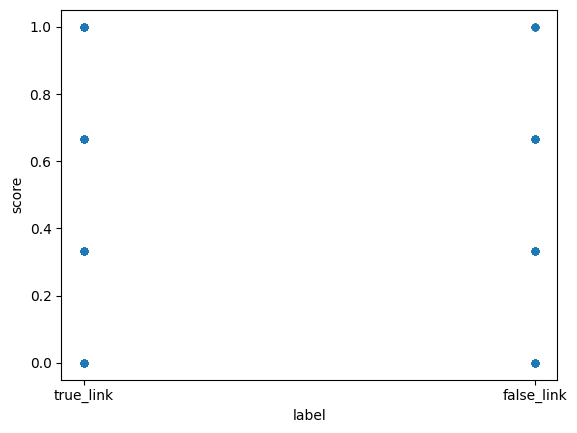

In [25]:
result.plot.scatter("label", "score")

In [26]:
result["neg"] = (result["num_neg"] / 10).fillna(0).astype(int)
result

,path_length,label,num_neg,score,random,neg
0,5,true_link,20.0,0.000000,0.101662,2
2,2,true_link,20.0,1.000000,1.977131,2
3,4,true_link,20.0,0.333333,0.375609,2
4,2,true_link,20.0,1.000000,1.092836,2
5,2,true_link,20.0,1.000000,1.188747,2
...,...,...,...,...,...,...
146298,5,false_link,NaN,0.000000,-0.321437,0
146303,5,false_link,20.0,0.000000,0.172624,2
146309,5,false_link,11.0,0.000000,-0.210307,1
146316,5,false_link,NaN,0.000000,0.223893,0


In [27]:
result[result["label"] == "true_link"].groupby(["path_length", "neg"]).count()['label']

path_length  neg
2            0       4475
             1       3574
             2      13489
3            0          3
             2        104
4            0        369
             1        261
             2      12281
5            0        216
             1         66
             2       3414
Name: label, dtype: int64

In [28]:
result[result["label"] == "false_link"].groupby(["path_length", "neg"]).count()['label']

path_length  neg
2            0         9
             2         3
3            0        23
             1         5
             2        35
4            0       299
             1        41
             2       589
5            0      2655
             1       286
             2      6766
Name: label, dtype: int64

In [29]:
result[result["label"] == "true_link"].groupby(["neg", "path_length"]).count()['label']

neg  path_length
0    2               4475
     3                  3
     4                369
     5                216
1    2               3574
     4                261
     5                 66
2    2              13489
     3                104
     4              12281
     5               3414
Name: label, dtype: int64

In [30]:
result[result["label"] == "false_link"].groupby(["neg", "path_length"]).count()['label']

neg  path_length
0    2                 9
     3                23
     4               299
     5              2655
1    3                 5
     4                41
     5               286
2    2                 3
     3                35
     4               589
     5              6766
Name: label, dtype: int64

<Axes: ylabel='Frequency'>

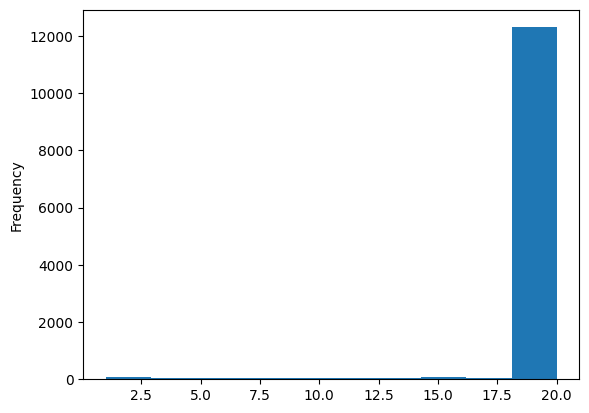

In [40]:
result.loc[(result["label"] == "true_link") & (result["path_length"] == 4), "num_neg"].plot.hist(bins=10)

<Axes: ylabel='Frequency'>

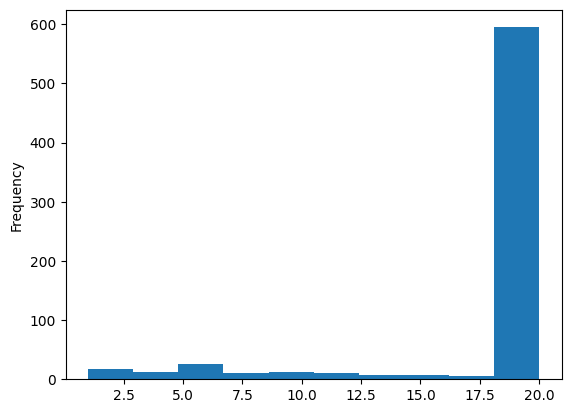

In [41]:
result.loc[(result["label"] == "false_link") & (result["path_length"] == 4), "num_neg"].plot.hist(bins=10)